# NFL Draft Impact on Wikipedia Views by Draft Round
This program explores the impact that each NFL draft round has on a given player's Wikipedia views. It seeks to answer questions including:
    *How many additional views does a player's Wikipedia page get once they are drafted into the NFL?
    *How many additional views is the first round worth compared to later rounds?

Methodology:
    1. Scrape 2018 NFL draft data from Pro-Football-Reference.com
    2. Collect Wikipedia page views for each drafted player using the mwviews API
    3. Employ ANCOVA analysis to compare pre-draft and post-draft mean Wikipedia page views by draft round 

### Setup

In [1]:
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import mwviews
from mwviews.api import PageviewsClient
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## 1) Scrape 2018 NFL draft data from Pro-Football-Reference.com
#### Source: scraping assistance from: http://savvastjortjoglou.com/nfl-draft.html#Web-Scraping

### Define scraping targets

In [2]:
# set the URL
draft_2018 = "https://www.pro-football-reference.com/years/2018/draft.htm"

# get html
html = urlopen(draft_2018)

# create the BeautifulSoup object
soup = BeautifulSoup(html, "lxml")

# Extract necessary values for the column headers from the table and store them as a list
headers = [th.getText() for th in soup.findAll('tr', limit=2)[1].findAll('th')]

# Add the two additional column headers for the player links
headers.extend(["Player_NFL_Link", "Player_NCAA_Link"])

# The data is found within the table rows of the element with id=draft
# We want the elements from the 3rd row and on
table_rows = soup.select("#drafts tr")[2:] 

# take a look at the first row
table_rows[0] 

<tr><th class="right " data-stat="draft_round" scope="row">1</th><td class="right " csk="0.5" data-stat="draft_pick">1</td><td class="left " csk="cle01" data-stat="team"><a href="/teams/cle/2018_draft.htm" title="Cleveland Browns">CLE</a></td><td class="left " csk="Mayfield,Baker" data-append-csv="MayfBa00" data-stat="player"><strong><a href="/players/M/MayfBa00.htm">Baker Mayfield</a></strong></td><td class="left " csk="QB--------0001" data-stat="pos">QB</td><td class="right " data-stat="age">23</td><td class="right " data-stat="year_max">2018</td><td class="right iz" data-stat="all_pros_first_team">0</td><td class="right iz" data-stat="pro_bowls">0</td><td class="right " data-stat="years_as_primary_starter">1</td><td class="right " data-stat="career_av">10</td><td class="right " data-stat="draft_av">10</td><td class="right " data-stat="g">14</td><td class="right " data-stat="pass_cmp">310</td><td class="right " data-stat="pass_att">486</td><td class="right " data-stat="pass_yds">3725

### Scrape data

In [3]:
def extract_player_data(table_rows):
    """
    Extract and return the the desired information from the td elements within the table rows.
    """
    # create the empty list to store the player data
    player_data = []
    
    for row in table_rows:  # for each row do the following

        # Get the text for each table data (td) element in the row
        # Some player names end with ' HOF'
        # if they do, get the text excluding those last 4 characters,
        # otherwise get all the text data from the table data
        player_list = [td.get_text() for td in row.find_all("th")]
        player_list.extend([td.get_text() for td in row.find_all("td")])

        # there are some empty table rows, which are the repeated 
        # column headers in the table
        # we skip over those rows and and continue the for loop
        if not player_list:
            continue

        # Extracting the player links
        # Instead of a list we create a dictionary, this way we can easily
        # match the player name with their pfr url
        # For all "a" elements in the row, get the text
        # NOTE: Same " HOF" text issue as the player_list above
        links_dict = {(link.get_text()[:-4]   # exclude the last 4 characters
                       if link.get_text().endswith(" HOF")  # if they are " HOF"
                       # else get all text, set thet as the dictionary key 
                       # and set the url as the value
                       else link.get_text()) : link["href"] 
                       for link in row.find_all("a", href=True)}

        # The data we want from the dictionary can be extracted using the
        # player's name, which returns us their pfr url, and "College Stats"
        # which returns us their college stats page
    
        # add the link associated to the player's pro-football-reference page, 
        # or en empty string if there is no link
        player_list.append(links_dict.get(player_list[3], ""))

        # add the link for the player's college stats or an empty string
        # if ther is no link
        player_list.append(links_dict.get("College Stats", ""))

        # Now append the data to list of data
        player_data.append(player_list)
        
    return player_data

# extract the data we want
data = extract_player_data(table_rows)

### Clean the data

In [4]:
# store it in a DataFrame
df_2018 = pd.DataFrame(data, columns=headers)
df_2018.columns

Index(['Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To', 'AP1', 'PB', 'St',
       'CarAV', 'DrAV', 'G', 'Cmp', 'Att', 'Yds', 'TD', 'Int', 'Att', 'Yds',
       'TD', 'Rec', 'Yds', 'TD', 'Solo', 'Int', 'Sk', 'College/Univ', '',
       'Player_NFL_Link', 'Player_NCAA_Link'],
      dtype='object')

In [5]:
# keep only necessary columns
df_2018 = df_2018[['Rnd','Pick','Tm','Player','Pos','College/Univ']]

# explore data
df_2018.head()

,Rnd,Pick,Tm,Player,Pos,College/Univ
0,1,1,CLE,Baker Mayfield,QB,Oklahoma
1,1,2,NYG,Saquon Barkley,RB,Penn St.
2,1,3,NYJ,Sam Darnold,QB,USC
3,1,4,CLE,Denzel Ward,CB,Ohio St.
4,1,5,DEN,Bradley Chubb,DE,North Carolina St.


In [6]:
df_2018.isna().sum()
# it looks like there are no missing values - a good sign

Rnd             0
Pick            0
Tm              0
Player          0
Pos             0
College/Univ    0
dtype: int64

In [7]:
df_2018.describe()
# there are only 257 (out of 262) unique names and the most common name is 'Player' 
# is this a data issue?
# also, with 32 teams and 7 rounds we should have 224 total picks, but there are 256 in this dataset

,Rnd,Pick,Tm,Player,Pos,College/Univ
count,262,262,262,262,262,262
unique,8,257,33,257,18,113
top,6,Pick,BAL,Player,WR,Alabama
freq,44,6,12,6,34,12


In [8]:
# let's dig further into these issues

# first, why are we seeing players named 'Player'?
df_2018[df_2018.Player == 'Player']
# it looks like the page we scraped included the table headers multiple times throughout the dataset

,Rnd,Pick,Tm,Player,Pos,College/Univ
32,Rnd,Pick,Tm,Player,Pos,College/Univ
65,Rnd,Pick,Tm,Player,Pos,College/Univ
102,Rnd,Pick,Tm,Player,Pos,College/Univ
140,Rnd,Pick,Tm,Player,Pos,College/Univ
178,Rnd,Pick,Tm,Player,Pos,College/Univ
223,Rnd,Pick,Tm,Player,Pos,College/Univ


In [9]:
# rows 32, 65, 102, 140, 178, and 223 contain header descriptions instead of actual observations 
# we need to remove these rows
df_2018=df_2018[(df_2018.Player!='Player')]

# and to double check our fix
df_2018[df_2018.Player=='Player']

,Rnd,Pick,Tm,Player,Pos,College/Univ


In [10]:
df_2018.describe()
# that looks better - we now have 256 unique names

,Rnd,Pick,Tm,Player,Pos,College/Univ
count,256,256,256,256,256,256
unique,7,256,32,256,17,112
top,6,45,BAL,Jordan Wilkins,WR,Alabama
freq,44,1,12,1,34,12


In [11]:
# now let's investigate the count of 256 draft picks
tabs=['Rnd']
for column in tabs:
    tab = pd.crosstab(index=df_2018[column],  # Make a crosstab
                              columns="count")      # Name the count column
    print(tab)

# apparently there are 32 picks in the first two rounds but later rounds have 36 - 44 picks
# this is verified by a quick Google search

col_0  count
Rnd         
1         32
2         32
3         36
4         37
5         37
6         44
7         38


## 2) Collect Wikipedia page views for each drafted player using the mwviews API

### Collect data

In [12]:
# sends a descriptive User-Agent header with every request
p = PageviewsClient(user_agent="<ene> NFL draft analysis")

# later in the program an error occurs as ProFootballReference and Wikipedia handle initials inconsistently
# Wiki also defaults to former player and CBS analyst Marcus Allen so we need to redirect to the 2018 drafted Marcus Allen
# let's manually correct this issue before we get to it
name_correction = {'M.J. Stewart':'M. J. Stewart',
                   'P.J. Hall':'P. J. Hall',
                   'R.J. McIntosh':'R. J. McIntosh',
                   'Marcus Allen':'Marcus Allen (safety)'
                  }
df_2018 = df_2018.replace(name_correction)

In [13]:
# 2018 NFL draft took place from April 26 to April 28
# we will collect more data than needed at beginning to allow for flexibility later on

# build dataframe format
wiki_views = pd.DataFrame.from_dict(p.article_views
                                    ('en.wikipedia', 
                                     df_2018.at[0,'Player'], 
                                     granularity='daily', 
                                     start='20180101', 
                                     end='20181231'
                                    ))

# remove data so that we a shell with the format we want
wiki_views = wiki_views[0:0]
wiki_views.head()

,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,2018-01-10 00:00:00,...,2018-12-22 00:00:00,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00


In [14]:
# populate table with wikipedia stats for every drafted player
for i in df_2018.index:
    wiki_views = wiki_views.append(pd.DataFrame.from_dict
                                    (p.article_views
                                     ('en.wikipedia', 
                                      df_2018.at[i,'Player'], 
                                      granularity='daily', 
                                      start='20180101', 
                                      end='20181231'
                                     )))

### Clean the data

In [15]:
# set column name for players
wiki_views['Player'] = wiki_views.index
wiki_views.head()

,2018-01-01 00:00:00,2018-01-02 00:00:00,2018-01-03 00:00:00,2018-01-04 00:00:00,2018-01-05 00:00:00,2018-01-06 00:00:00,2018-01-07 00:00:00,2018-01-08 00:00:00,2018-01-09 00:00:00,2018-01-10 00:00:00,...,2018-12-23 00:00:00,2018-12-24 00:00:00,2018-12-25 00:00:00,2018-12-26 00:00:00,2018-12-27 00:00:00,2018-12-28 00:00:00,2018-12-29 00:00:00,2018-12-30 00:00:00,2018-12-31 00:00:00,Player
Baker_Mayfield,114799,217002,23490,12327,12433,7905,7200,5813,9517,4773,...,13777,16978,7636,6404,8799,7344,8333,26923,31812,Baker_Mayfield
Saquon_Barkley,12665,6743,4279,4054,3031,2526,2494,1906,2270,1470,...,4051,2611,1895,1630,1683,1776,1733,15988,7439,Saquon_Barkley
Sam_Darnold,2344,3239,1723,11829,4066,1808,1908,1426,1799,1136,...,4134,2434,1436,1162,1191,1123,1207,7104,3019,Sam_Darnold
Denzel_Ward,242,257,188,207,191,153,108,171,152,136,...,1357,1230,777,638,660,725,656,938,1266,Denzel_Ward
Bradley_Chubb,1732,3342,768,738,527,473,454,646,1737,517,...,949,933,2369,654,786,697,526,862,1221,Bradley_Chubb


In [16]:
# pivot our df so that date is a column
wiki_views = pd.melt(wiki_views, id_vars=["Player"],var_name="Date", value_name="Views")
wiki_views.head()

,Player,Date,Views
0,Baker_Mayfield,2018-01-01,114799
1,Saquon_Barkley,2018-01-01,12665
2,Sam_Darnold,2018-01-01,2344
3,Denzel_Ward,2018-01-01,242
4,Bradley_Chubb,2018-01-01,1732


In [17]:
# remove underscore that wikipedia enters into player names 
# this ensures we can join to draft data later on using player name 
wiki_views = wiki_views.replace('_', ' ', regex=True)

In [18]:
# explore data

# check for NAs 
wiki_views.isna().sum()
# the player and date fields are complete, but we have 13,976 instances where there were no views
# we need to replace these NAs with 0s

Player        0
Date          0
Views     13976
dtype: int64

In [19]:
# replace NAs with 0s 
wiki_views=wiki_views.fillna(0)

In [20]:
# double check our fix
wiki_views.isna().sum()

Player    0
Date      0
Views     0
dtype: int64

In [21]:
#continue data exploration
wiki_views.describe()

,Views
count,93440.000000
mean,233.924658
std,1956.427776
min,0.000000
25%,10.000000
50%,45.000000
75%,121.000000
max,217002.000000


In [22]:
wiki_views.shape

(93440, 3)

## 3 Apply ANCOVA analysis to compare pre-draft and post-draft mean Wikipedia page views by draft round 

### Join data from steps 1 and 2

In [23]:
# merge Wikipedia and draft data on player name
draft_round = df_2018[['Player','Rnd']]
merged = pd.merge(wiki_views,draft_round,on='Player',how='left')

In [24]:
# define pre and post periods
# 2018 NFL draft took place from April 26 to April 28

# pre period begins in Feb after all college bowl games are complete and ends a week before the draft
pre = (merged['Date'] >= '2018-02-05') & (merged['Date'] <= '2018-04-19')

# post period begins first day of the draft and extends a week after the draft is complete
post = (merged['Date'] >= '2018-04-26') & (merged['Date'] <= '2018-05-05')

### Clean the new dataframe

In [25]:
# limit to pre-period, rename Views to Pre_views, and keep only Player, Views, and Rnd columns
predata=merged[['Player','Views','Rnd']].loc[pre].rename(index=str,columns={"Views":"Pre_views"})

# calculate mean daily Wikipedia page views in pre-period
predata=predata.groupby(['Player','Rnd'],as_index=False)['Pre_views'].mean()

# limit to post-period, rename Views to Post_views, and keep only Player, Views, and Rnd columns
postdata=merged[['Player','Views','Rnd']].loc[post].rename(index=str,columns={"Views":"Post_views"})

# calculate mean daily Wikipedia page views in post-period
postdata=postdata.groupby(['Player'],as_index=False)['Post_views'].mean()

# merge pre and post into single df
totdata=pd.merge(predata,postdata,on='Player',how='left')

# drop Player column which is no longer necessary
#totdata=totdata.drop(columns='Player')
totdata.head()

,Player,Rnd,Pre_views,Post_views
0,Ade Aruna,6,0.000000,141.6
1,Alex Cappa,3,3.418919,537.4
2,Alex McGough,7,0.000000,531.9
3,Andre Smith,7,6.689189,22.1
4,Andrew Brown,5,10.351351,19.8


### Explore relationships between dependent and independent variables

In [26]:
totdata.columns

Index(['Player', 'Rnd', 'Pre_views', 'Post_views'], dtype='object')

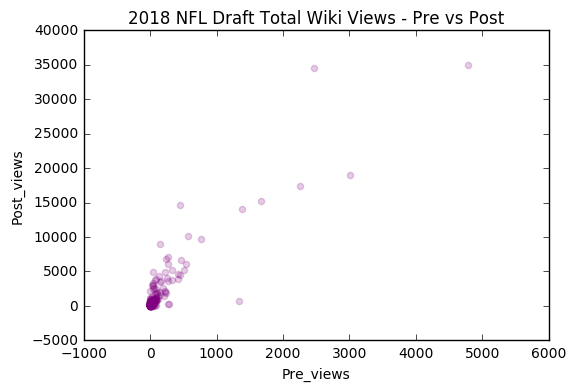

In [27]:
# plot Pre_views against Post_views to ensure there is a relationship
plt.scatter(totdata['Pre_views'], totdata['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Total Wiki Views - Pre vs Post", fontdict=None, loc='center');

# a relationship exists as the number of views increases, but most observations are close to 0
# the post_views figures are many times larger than the pre_views 
# which shows that there is a large jump in Wiki views after the draft

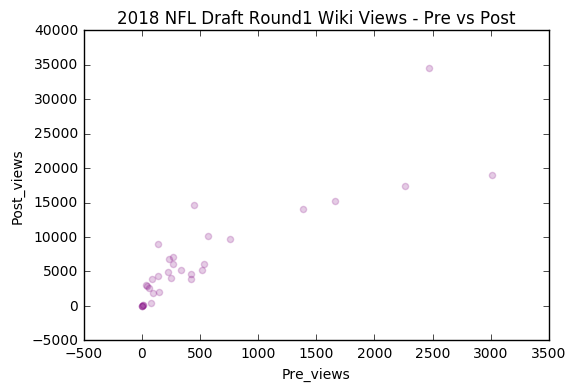

In [28]:
# complete the same view for the first round
plt.scatter(totdata[totdata.Rnd=='1']['Pre_views'], totdata[totdata.Rnd=='1']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round1 Wiki Views - Pre vs Post", fontdict=None, loc='center');

# there is a pretty strong relationship here

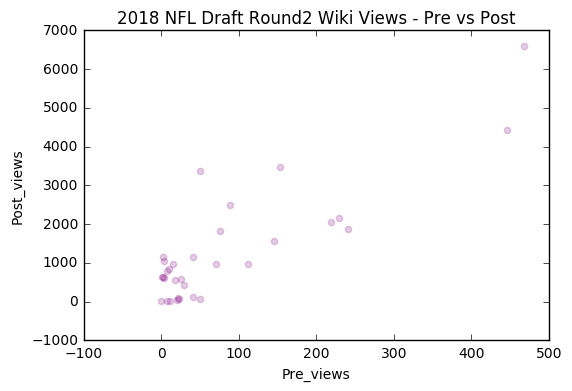

In [29]:
 # complete the same view for the second round
plt.scatter(totdata[totdata.Rnd=='2']['Pre_views'], totdata[totdata.Rnd=='2']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round2 Wiki Views - Pre vs Post", fontdict=None, loc='center');

# the relationship is still strong, but notice the drastic reduction in the figures on the axes

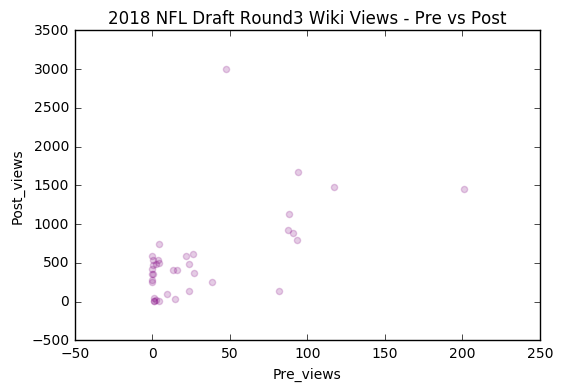

In [30]:
# complete the same view for the third round
plt.scatter(totdata[totdata.Rnd=='3']['Pre_views'], totdata[totdata.Rnd=='3']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round3 Wiki Views - Pre vs Post", fontdict=None, loc='center');

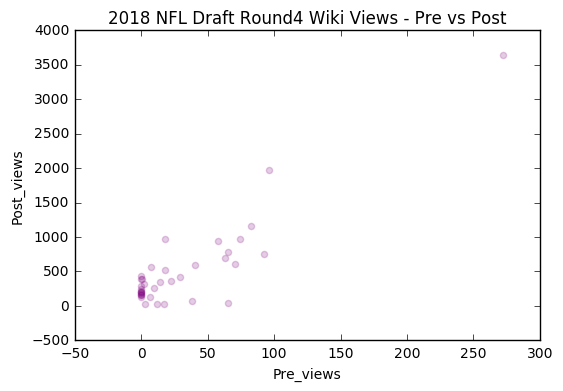

In [31]:
# complete the same view for the fourth round
plt.scatter(totdata[totdata.Rnd=='4']['Pre_views'], totdata[totdata.Rnd=='4']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round4 Wiki Views - Pre vs Post", fontdict=None, loc='center');

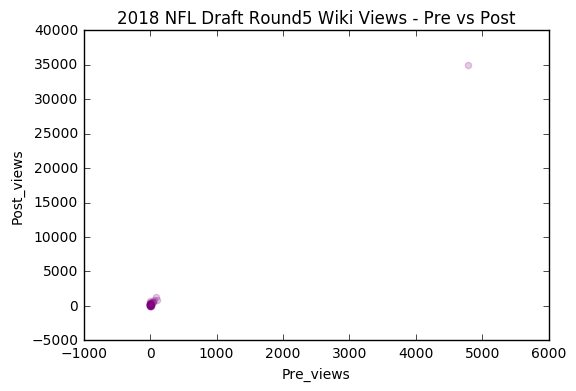

In [32]:
# complete the same view for the fifth round
plt.scatter(totdata[totdata.Rnd=='5']['Pre_views'], totdata[totdata.Rnd=='5']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round5 Wiki Views - Pre vs Post", fontdict=None, loc='center');

# note: the fifth round has a clear outlier

In [33]:
# let's figure out why this fifth round pick is getting more views than the first round picks
fifthrnd = totdata[totdata.Rnd=='5']
fifthrnd[fifthrnd.Pre_views>1000]

# Shaquem Griffin appears to be the outlier here
# this is likely due to the significant news coverage he received since he is an amputee with one hand
# his story is incredible! https://www.nytimes.com/2018/09/18/opinion/shaquem-griffin-football-amputee.html

,Player,Rnd,Pre_views,Post_views
222,Shaquem Griffin,5,4786.756757,34945.0


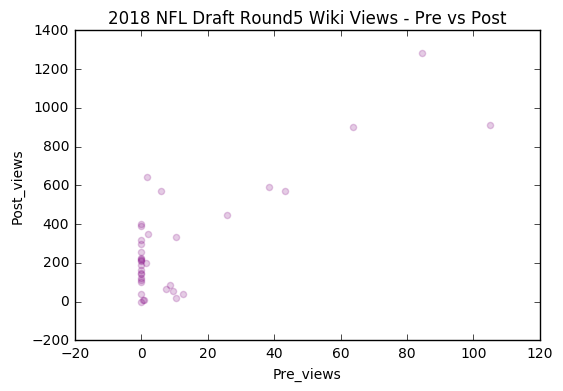

In [34]:
# let's remove Shaquem so that his media coverage and high Wiki views don't bias the results of the 5th round of our model
totdata=totdata[totdata.Player != 'Shaquem Griffin']

# and let's replot the fifth round
plt.scatter(totdata[totdata.Rnd=='5']['Pre_views'], totdata[totdata.Rnd=='5']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round5 Wiki Views - Pre vs Post", fontdict=None, loc='center');

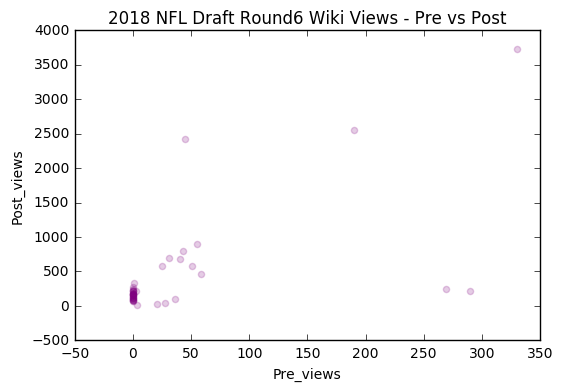

In [35]:
# complete the same view for the sixth round
plt.scatter(totdata[totdata.Rnd=='6']['Pre_views'], totdata[totdata.Rnd=='6']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round6 Wiki Views - Pre vs Post", fontdict=None, loc='center');

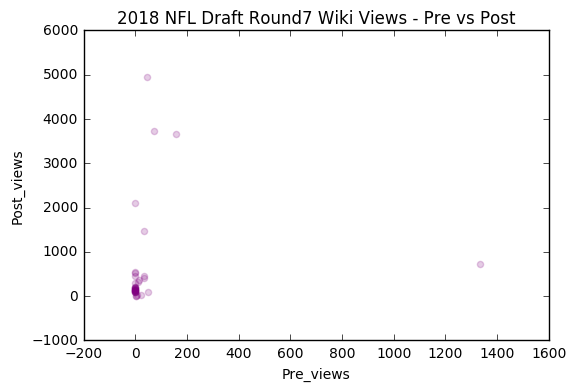

In [36]:
# complete the same view for the seventh round
plt.scatter(totdata[totdata.Rnd=='7']['Pre_views'], totdata[totdata.Rnd=='7']['Post_views'], alpha=0.2, color="purple")
plt.xlabel(totdata.columns[2])
plt.ylabel(totdata.columns[3])
plt.title("2018 NFL Draft Round7 Wiki Views - Pre vs Post", fontdict=None, loc='center');

# relationship between pre and post is fairly week by the 7th round 
# this is driven by the lower number of pre-period Wiki page visits for all players drafted this late

### Execute ANCOVA

In [37]:
from statsmodels.formula.api import ols

# build and execute model
formula = 'Post_views ~ Pre_views + Rnd'
lm = ols(formula, totdata).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             Post_views   R-squared:                       0.799
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     140.6
Date:                Fri, 22 Mar 2019   Prob (F-statistic):           2.06e-82
Time:                        11:00:18   Log-Likelihood:                -2229.7
No. Observations:                 255   AIC:                             4475.
Df Residuals:                     247   BIC:                             4504.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   2839.6897    324.837      8.742      0.0

### RESULTS
    * Post_views = 2,840 + 7.6*Pre_views + Rnd
    * There is a statistically significant reduction in page views if a player is drafted later than the 1st round
    * The impact of being drafted in rounds 2 - 7 is estimated at ~ 2.2K to 2.6K fewer daily post period page views 
      than if the  player had been drafted in the 1st round
    * While the coefficients show an estimated decrease in impact to page visits as the draft round increases, 
      there is a significant overlap in the confidence internals even between rounds 2 and 7. 
      Thus, there is no statistical conclusion that being drafted in round 2 provides more views 
      than being drafted in a later round